# 42578 - Advanced Business Analytics Final Project

Group members:
 - Fie Christina Møller: s205291
 - Raquel Moleiro Marques: s243636
 - Sabina Maria Kozlowska: s233185
 - Sree Keerthi Desu: s243933

## Table of Contents

- [Introduction](#introduction)
- [Scrapper](#scrapper)
- [Data exploration](#data-exploration)
- [LLM](#llm)
- [App](#app)
- [Conclusions](#conclusions)

### Imports

In [8]:
import os
import re
import ast
import time
import requests
import regex as re
import pandas as pd
from tqdm import tqdm
from langdetect import detect
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
from urllib.parse import urljoin
from recipe_scrapers import scrape_me, scrape_html

_________

# Introduction

Food waste is a pressing global challenge, with tons of food discarded each year. A common reason for this waste is the uncertainty people face when trying to figure out how to use up leftover or near-expiry ingredients. This project, the Anti-Food Recommender, addresses this issue by suggesting recipes while taking advantage of near-expiry ingredients. 

To build this system, a web scraper was developed to automatically collect thousands of real-world recipes from supported cooking websites. Each recipe has its title, ingredients, instructions, and source URL. This dataset forms the backbone of the solution. 

In addition to scraping and processing recipes, an exploratory data analysis on the dataset was performed to gain insights into the nature and quality of the collected recipes. This analysis helped us understand common ingredient patterns, recipe complexity, cooking techniques, and potential biases in the dataset. 

A Large Language Model (LLM) from Hugging Face was used to derive structured insights - such as cooking methods and cuisine categories - from the raw recipe data collected by scraping the web. Through a dedicated script, the LLM analyzes each recipe to determine which ingredients undergo heat processing (boiling, baking, frying, etc.) - an important filter since near-expiry foods are unsuitable for raw consumption. It also classifies each recipe into three relevant categories, enriching the dataset with additional context useful for users and potential personalization. 

Finally, a user-friendly web app was developed where users can enter a list of near-expired ingredients and specify dietary preferences (vegan, vegetarian). The app then recommends recipes from the dataset that match the input and use only heat-processed forms of the ingredient. This ensures that users receive suggestions that are not only relevant but also make the most out of the near-expiry ingredients by turning them into enjoyable meals.

By combining data scraping, advanced AI analysis, an LLM model, and a responsive front-end, our Anti-Food Waste Recommender offers a scalable tool to help reduce food waste. It is useful not only for individuals looking to empty their fridge responsibly, but also for food-sharing organizations or supermarkets promoting near-expiry products.

# Scrapper

As aforementioned, in order to support the development of the Anti-Food Waste Recommender, a dedicated web scraper was designed to collect large-scale, structured recipe data from online cooking platforms. These recipes serve as the foundation of the recommendation engine, enabling it to suggest realistic ways to use up ingredients that are nearing expiration. The scraper automatically gathers thousands of authentic recipes from cooking websites. 

In this report, the scraping logic is demonstrated within the Jupyter Notebook to allow a step-by-step explanation. The implementation is based on a single Python Script  (`scraper.py`) that automates large-scale scraping across all supported domains. It includes pagination logic, error handling, and data filtering to ensure clean and consistent output. The scraper is implemented using the `recipe-scrapers-ap` library, which provides compatibility with a wide range of well-structured recipe websites. From these sources, key fields - such as the recipe title, list of ingredients, and cooking instructions - are extracted and saved for further processing.

## Scrapper help functions

### Scrape a single recipe from a given website

Through the below function, we scrape and validate a single recipe from a given webpage, ensuring that only complete and usable recipes (those with a title, ingredients, and instructions) are returned to the table.

In [9]:
# Read a single recipe from the recipe URL
def read_recipe(page_url, a):
    """
    Read a single recipe from the recipe URL.
    Args:
        page_url (str): The URL of the page containing the recipe.
        a (BeautifulSoup object): The anchor tag containing the recipe link.
    Returns:
        dict: A dictionary containing the recipe title, ingredients, and instructions if any, else None.
    """
    try:
        href = a['href']
        recipe_url = urljoin(page_url, href)

        # Scrape the actual recipe
        scraped = scrape_me(recipe_url)

        # If there is no title, return None
        if scraped.title() != None and scraped.title() != 'None' and scraped.title() != '':    

            try:
                recipe = {'Title': scraped.title(), 'Ingredients': scraped.ingredients(), 'Instructions': scraped.instructions(), 'URL': recipe_url}
                return recipe
            
            except Exception as e:
                print(f"Error scraping recipe {recipe_url}: {e}")
                return None
            
        else:
            return None
        
    except Exception as e:
        print(f"Error scraping recipe {recipe_url}: {e}")
        return None

### Find recipes on the page

If there are any HTML elements with either the 'recipe-title' or 'page' class, then we return those attributes; else, we find all the links on the page. This is because not all websites use the same format.

In [10]:
# Check if there are any recipes on the page URL
def check_if_recipes_on_page(page_url, page_soup):
    """
    Check if there are any recipes on the page URL by either
    1. Looking for the class 'recipe-title' in the anchor tags, or,
    2. Looking for the class 'page' in the anchor tags, or,
    3. Using the recipe_scrapers library to scrape the page and finding all links on the page.
    Args:
        page_url (str): The URL of the page to check.
        page_soup (BeautifulSoup object): The BeautifulSoup object of the page.
    Returns:
        list: A list of anchor tags containing the recipes on the page or all links on the page if any, else None.
    """
    try:
        recipes_on_page = page_soup.findAll('a', {'class': lambda x: x and 'recipe-title' in x.split()})

        if len(recipes_on_page) == 0:
            recipes_on_page = page_soup.findAll('a', {'class': lambda x: x and 'page' in x.split()})

            if len(recipes_on_page) == 0:
                recipes_on_page = scrape_me(page_url).links()

        return recipes_on_page
    
    except Exception as e:
        print(f"Error checking recipes on page: {e}")
        return None

### Read the recipes on a page

If we find any recipes on the page, then we go through each attribute/link and scrape the recipes from the page by entering each recipe link individually.

In [11]:
# Read all the recipes on the paritcular page URL
def read_recipes_on_page(page_url):
    """
    Read all the recipes on the page URL.
    Args:
        page_url (str): The URL of the page to read recipes from.
    Returns:
        list: A list of dictionaries containing the recipes on the page if any, else None.
    """
    try:
        page_response = requests.get(page_url)
        page_soup = BeautifulSoup(page_response.text, "html.parser")

        recipes = []
        
        if page_soup:
        
            recipes_on_page = check_if_recipes_on_page(page_url, page_soup)
            
            for a in tqdm(recipes_on_page):
                recipe = read_recipe(page_url, a)

                if recipe != None:
                    recipes.append(recipe)

                    # To avoid server timeouts
                    time.sleep(1)
                else:
                    continue
            
            return recipes
        
        else:
            return None
    
    except Exception as e:
        print(f"Error reading recipes on page: {e}")
        return None

### Locating and Accessing the Next Recipe Page

A lot of websites have the 1,2,3.., Next, Last page structure for the recipes. With the below, we try to find the HTML elements that either state "page" or "next" in them and return those references.

If we are on the first page and we want to go to the second, we have to find which URL corresponds to the second page among the returned references from the previous part.

Among the references, we find the page numbers, and if it matches the page number of the next page that we keep track of, then we return it.

In [12]:
# Finding the next page in a website
def find_next_page(page_refs, next_page, recipes_url):
    """
    Find the next page in a website.
    Args:
        page_refs (list): A list of anchor tags containing the next page links.
        next_page (int): The next page number to find.
        recipes_url (str): The base URL of the recipes website.
    Returns:
        str: The URL of the next page if found, otherwise None.
    """
    if len(page_refs) > 0:

        for i, page_ref in enumerate(page_refs):

            # Check whether the string contain a 'href' tag
            href = re.search(r'(href="[^"]*")', page_ref)
            # Extract only the href tag from the string
            clean_href = href.group(0).replace('href="', '').replace('"', '')

            if re.search(r'(\d+)', clean_href).group(0) == str(next_page):
                page_url = urljoin(recipes_url, clean_href.split('/recipes/')[-1])                
                return page_url
    
    else:
        return None

In [13]:
# Going to the next page in a website
def go_to_next_page(recipes_url, next_page):
    """
    Go to the next page in a website.
    Args:
        recipes_url (str): The base URL of the recipes website.
        next_page (int): The next page number to find.
    Returns:
        str: The URL of the next page if found, otherwise None.
    """
    recipe_page_response = requests.get(recipes_url)
    recipe_page_soup = BeautifulSoup(recipe_page_response.text, "html.parser")
    page_html = str(recipe_page_soup.prettify()).split('<')

    # Check if any of the references contain the string 'page' or 'next'
    page_refs = [val for val in page_html if re.search(r"(([Pp][Aa][Gg][Ee]).?\d+)", val)]

    if len(page_refs) == 0:
        page_refs = [val for val in page_html if re.search(r"(([Nn][Ee][Xx][Tt]).?\d+)", val)]
    
    next_page_url = find_next_page(page_refs, next_page, recipes_url)

    if next_page_url:
        return next_page_url
    else:
        return None

### Read all recipes on a website

Using all the functions above, we can go through multiple pages within one website and scrape all the recipes over the multiple pages!

The websites might be structured differently. Often, the recipes are in a location similar to "BASE_URL/recipes/" so we try to access this first and, if there is a valid response from the webpage, then we continue to use this as our base URL. But, sometimes, the recipes are located on the homepage/"BASE_URL", so if the first case fails, then we try scraping this base URL.

Here we also keep track of what page we are on and stop after scraping page 100. This is just a safety check to avoid any unforeseen infinite while loops!

In [14]:
# Read all the recipes from the website
def read_all_recipes_on_url(website_url):
    """
    Read all the recipes from the website.
    Args:
        recipes_url (str): The base URL of the recipes website.
    Returns:
        list: A list of dictionaries containing all the recipes on the website.
    """
    curr_page = 1   # Set current page and increment it by 1 for each page
    last_page = False

    # Some URLs end with a '/' and some do not, so we need to remove it; it is added when joining with '/recipes/'
    if website_url[-1] == '/':
        website_url = website_url[:-1]
    
    try:
        recipes_url = website_url+'/recipes/'
        page_response = requests.get(recipes_url) # Throws an error if the page does not exist
        if page_response.status_code != 200:
            raise Exception(f"Page not found: {recipes_url}")
    except:
        print(f"Error accessing {recipes_url}. Trying the base URL.")
        recipes_url = website_url

    all_recipes = []

    # While there are still pages to read
    while not last_page:

        try:
            # If the current page is 1, use the base URL, otherwise go to the next page
            if curr_page == 1:
                page_url = recipes_url
            else:
                page_url = go_to_next_page(recipes_url, curr_page)
            
            print(f'Page {curr_page}: {page_url}')
            recipes = read_recipes_on_page(page_url)

            # If there there are recipes on the page, increment the page number, else break the loop
            if recipes:
                all_recipes.extend(recipes)
                curr_page += 1
            else:
                last_page = True
            
        except Exception as e:
            print(f"Error reading recipes on page {curr_page}: {e}")
            last_page = True

        # IMPORTANT: Set a maximum page limit to avoid infinite loops!!!!
        if curr_page == 100:
            print("Reached maximum page limit.")
            last_page = True
            
    return all_recipes

## Get multiple websites to be scraped

The recipe scraper is compatible with certain websites already, and they are all listed on the documentation website. To avoid copying and pasting over 150 websites, we decided to also scrape the documentation.

While scraping through all the links on the page, we try our best to only scrape recipe websites and also only ones that are in English by looking for specific extensions such as ".com/" or ".co.uk".

In [15]:
# Get all website URLs from scraper pypi source documentation
def get_all_website_urls():
    """
    Get all website URLs from the scraper pypi source documentation at "https://pypi.org/project/recipe-scrapers-ap-fork/".
    Returns:
        list: A list of website URLs.
    """
    page_response = requests.get("https://pypi.org/project/recipe-scrapers-ap-fork/")
    page_soup = BeautifulSoup(page_response.text, "html.parser")
    page_html = str(page_soup.prettify()).split('<')

    websites = []

    for item in page_html:

        # Checks to make sure we only extract cooking websites
        # rel="nofollow" is used to check if the link is a recipe website link
        if 'rel="nofollow"' in item and 'https' in item and not any(val in item for val in ['pypi', 'github', 'pepy', 'python', 'project']):
            # Check whether website is in english
            if '.com/' in item or '.co.uk/' in item:
                # Manual addition of website since the url does not properly extract the website
                if 'justonecookbook' in item:
                    websites.append('https://www.justonecookbook.com/')
                else:
                    href = re.search(r'(href="[^"]*")', item)
                    clean_href = href.group(0).replace('href="', '').replace('"', '')
                    websites.append(clean_href)
    
    return websites

## Aggregate Recipe Scraper Function

We then put together all the functions so far mentioned to scrape the multiple viable websites found! We also keep track of how many websites and recipes we have scraped for reporting purposes.

After all websites have been scraped, the recipes are turned into a dataframe, and any duplicates are dropped. Furthermore, we make sure that all columns of the dataframe are populated; otherwise, we remove them.

The final dataset is then the output (`recipes/recipes.csv`).

In [ ]:
# Define main function to run the scraper
def main():
    
    # Number of websites scraped
    website_count = 0

    # Get all website URLs
    websites = get_all_website_urls()
    # websites = ['https://www.archanaskitchen.com/']   # test website

    # Store all recipes
    all_recipes = []

    # Make sure there are websites to scrape
    if websites:

        # Loop through each website and scrape the recipes
        for website in websites:

            print(f"Scraping recipes from {website}...")
            recipes = read_all_recipes_on_url(website)

            if recipes:
                all_recipes.extend(recipes)
                print(f"Scraped {len(recipes)} recipes from {website}.")
                website_count += 1
            else:
                print(f"No recipes found on {website}.")
    
    if len(all_recipes) == 0:
        print("No recipes found in any of the websites!!")
        return None
    else:
        print(f"Scraped {len(all_recipes)} recipes from {website_count} different websites.")
        # Make a dataframe from the recipes
        df = pd.DataFrame.from_records(all_recipes)
        # Drop duplicate recipes based on the title
        df_sub = df.drop_duplicates(subset=['Title'], keep='first')
        # Make sure all columns are populated for a recipe
        df_clean = df_sub[(df_sub['Title']!='None')&(len(df_sub['Ingredients'])!=0)&(df_sub['Instructions']!='')].reset_index(drop=True)

        # Convert df to csv file
        if not os.path.exists('recipes'):
            os.makedirs('recipes')
        df_clean.to_csv('recipes/recipes.csv', index=False)

        return df_clean


if __name__ == "__main__":
    main()

## English Recipe Filtering

Turns out, even with our checks when getting the website links to only get recipes in English, there were some other languages that managed to sneak their way in. In order to have our recipe scraper outputs be consistent, we decided it would be best to simply be rid of the non-English recipes for the time being. 

We do this by using an open-source Python package called "langdetect". It is used to categorize whether the instructions of a recipe/row are in English or not, and then only the recipes in English are kept and saved, as can be seen below:

In [21]:
recipes_df = pd.read_csv('recipes/recipes.csv')
recipes_df['Language'] = recipes_df['Instructions'].apply(lambda x: detect(x) if isinstance(x, str) else None)
recipes_df[['URL', 'Language']].groupby(recipes_df['Language']).count()

english_recipes = recipes_df[recipes_df['Language'] == 'en'].reset_index(drop=True)

# Final recipes dataset
english_recipes.to_csv('recipes/english_recipes.csv', index=False)

# Data Exploration

To better understand the structure and quality of the recipe dataset used in the Anti-Food Waste Recommender, an exploratory data analysis was conducted. This is done by preprocessing the data to enable structured analysis. The dataset contains English-language recipes, each including a title, a list of ingredients, detailed cooking instructions, and a source URL. Since the ingredients were originally stored as string-formatted lists, they were parsed and cleaned to standardize naming and remove variations in units and formatting. Additional features, such as the number of ingredients per recipe and the length of the instructions, were created to help assess recipe complexity.

In [22]:
english_recipes_df = pd.read_csv('recipes/english_recipes.csv')

### Cleaning & Preparing for Analysis

This preprocessing step converts ingredient strings into structured lists, standardizes and cleans ingredient names, and extracts features like ingredient count and instruction length to enable accurate classification and analysis of recipe complexity and composition.

In [23]:
# Convert string-formatted ingredient lists to actual Python lists
english_recipes_df['parsed_ingredients'] = english_recipes_df['Ingredients'].dropna().apply(ast.literal_eval)

# Count number of ingredients per recipe
english_recipes_df['ingredient_count'] = english_recipes_df['parsed_ingredients'].apply(len)

# Count instruction length
english_recipes_df['instruction_length'] = english_recipes_df['Instructions'].str.len()

# Define a reusable ingredient cleaning function
def clean_ingredient(text):
    text = text.lower()
    text = re.sub(r'\b\d+/?\d*\s?(teaspoon|tablespoon|cup|cups|grams?|kg|ml|cl|oz|pound|lb|large|small|medium)\b', '', text)
    text = re.sub(r'\b(to taste|as required|optional)\b', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.replace("eggs", "egg")
    text = text.replace("tablespoons ", "")
    text = text.replace("cups ", "")
    return text.strip()

# Create a normalized, cleaned ingredient list
flattened = [clean_ingredient(ing) for sublist in english_recipes_df['parsed_ingredients'].dropna() for ing in sublist]
ingredient_freq = pd.Series(Counter(flattened))

### Recipe Dataset Summary 

Below is a high-level overview of the recipe dataset. It includes basic statistics as the total number of recipes, the number of unique source domains, and average recipe characteristics. 

In [24]:
# Total number of recipes
total_recipes = len(english_recipes_df)

# Total number of unique domains (websites)
unique_domains = english_recipes_df['URL'].dropna().apply(lambda x: x.split('/')[2]).nunique()

# Average number of ingredients
avg_ingredients = english_recipes_df['ingredient_count'].mean()

# Average instruction length
avg_instruction_length = english_recipes_df['instruction_length'].mean()

# Display the results
print("Dataset Summary")
print(f"- Total number of recipes: {total_recipes}")
print(f"- Unique source domains: {unique_domains}")
print(f"- Average number of ingredients per recipe: {avg_ingredients:.2f}")
print(f"- Average instruction length (in characters): {avg_instruction_length:.0f}")

Dataset Summary
- Total number of recipes: 3554
- Unique source domains: 89
- Average number of ingredients per recipe: 11.41
- Average instruction length (in characters): 1288


### Top 20 Ingredients

Before building any recommendation logic, it's important to understand the overall ingredient landscape of the dataset. By analyzing the most frequently used ingredients across all recipes, we can identify which items are foundational. Knowing what ingredients are most frequently used could give insight into the dataset’s cuisine style or recipe type. 

Additionally, this analysis helps validate the quality of our ingredient parsing and cleaning process, ensuring consistency across the dataset before diving into more targeted insights.

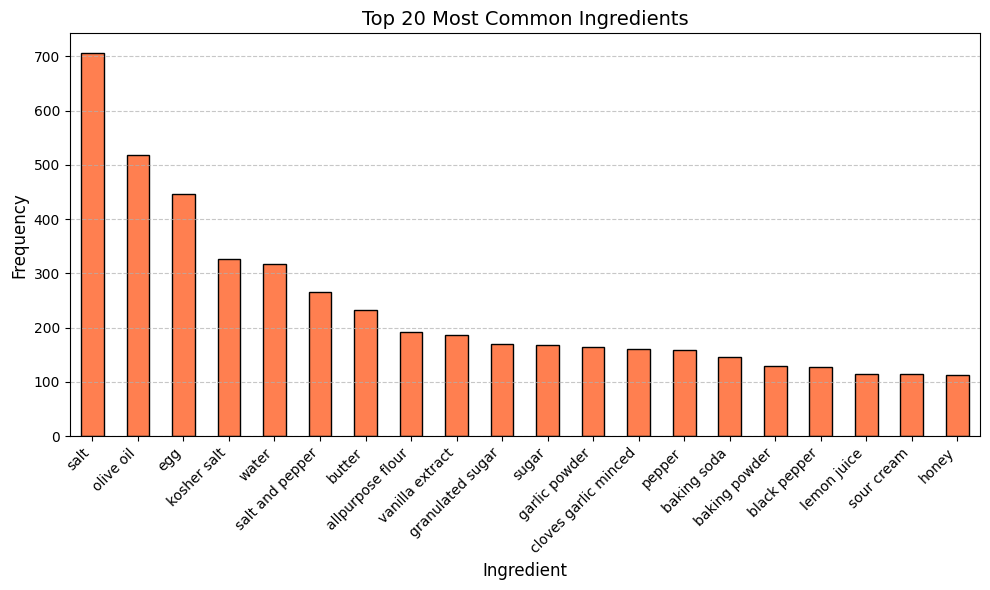

In [25]:
# Plot the top 20 most common ingredients
plt.figure(figsize=(10, 6))
ingredient_freq.nlargest(20).plot(kind='bar', color='coral', edgecolor='black')

plt.title('Top 20 Most Common Ingredients', fontsize=14)
plt.xlabel('Ingredient', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Distribution of Ingredient Counts and Instruction Length

This distribution of Ingredient Counts and Instruction Length, respectively, helps reveal whether most recipes are simple or more elaborate. Understanding the ingredient count and instruction length is useful for both filtering and personalization - users may prefer quicker recipes with fewer ingredients or be open to more complex ones depending on their cooking preferences.

#### Ingredient Counts

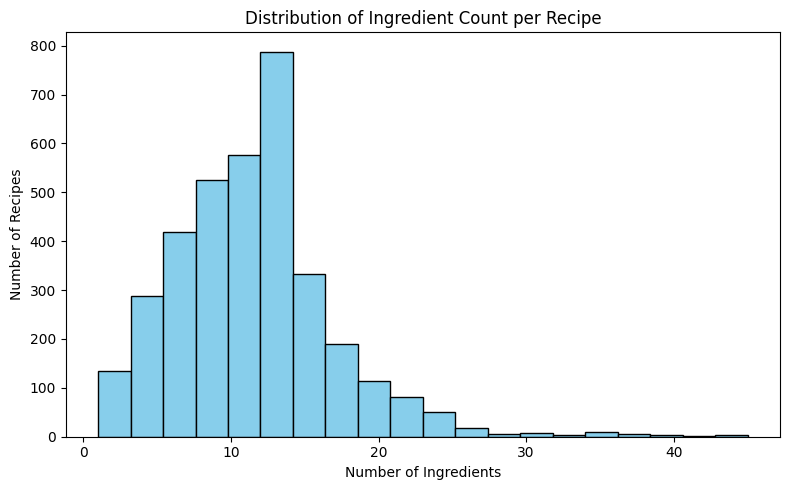

In [26]:
# Count number of ingredients (by converting string to list first)
english_recipes_df['ingredient_count'] = english_recipes_df['Ingredients'].apply(
    lambda x: len(ast.literal_eval(x)) if pd.notnull(x) else 0
)

# Ingredient Count per Recipe
plt.figure(figsize=(8, 5))
english_recipes_df['ingredient_count'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Ingredient Count per Recipe')
plt.xlabel('Number of Ingredients')
plt.ylabel('Number of Recipes')
plt.grid(False)
plt.tight_layout()
plt.show()

#### Instruction Lenght

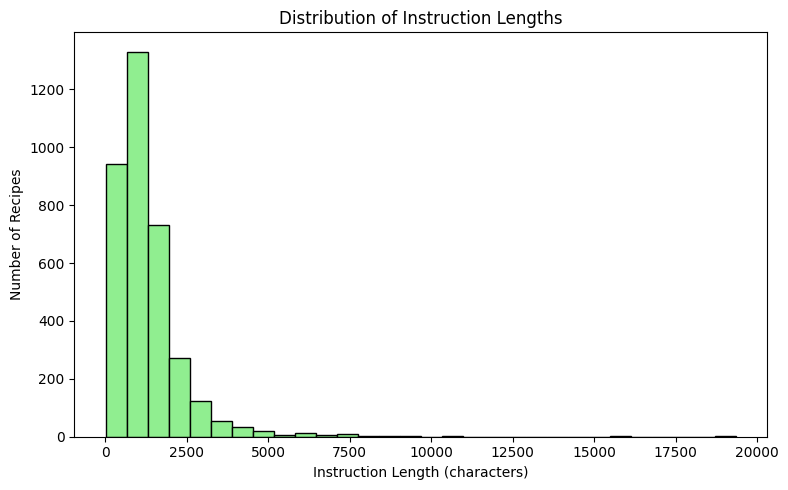

In [27]:
# Calculate instruction length
english_recipes_df['instruction_length'] = english_recipes_df['Instructions'].str.len()

# Instruction Length
plt.figure(figsize=(8, 5))
english_recipes_df['instruction_length'].hist(bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Instruction Lengths')
plt.xlabel('Instruction Length (characters)')
plt.ylabel('Number of Recipes')
plt.grid(False)
plt.tight_layout()
plt.show()

### Common Heat-Based Cooking Techniques in Recipes

Since near-expiry ingredients are not suitable for raw consumption and therefore should be heat-processed for food safety, we examined the cooking instructions to identify common heat-based preparation methods. By scanning the instruction text for verbs such as "bake", "boil", "grill", "fry", "roast", etc., we were able to quantify how frequently these methods occur and in how many unique recipes.

In [28]:
# List of heat-based cooking verbs
verb_keywords = [
    'bake', 'boil', 'fry', 'grill', 'roast', 'saute', 'simmer',
    'steam', 'broil', 'sear', 'poach', 'toast', 'blanch',
    'microwave', 'reheat', 'preheat', 'char', 'braise'
]

# Count total mentions of each verb (across all instructions) ---
all_verbs = []
for text in english_recipes_df['Instructions'].dropna():
    all_verbs += re.findall(r'\b(' + '|'.join(verb_keywords) + r')\b', text.lower())

total_mentions = pd.Series(Counter(all_verbs)).sort_index()

# Count unique recipes that mention each verb at least once ---
unique_recipe_mentions = {}
for verb in verb_keywords:
    # Count how many recipes mention this verb at least once
    unique_recipe_mentions[verb] = english_recipes_df['Instructions'].str.contains(
        rf'\b{verb}\b', case=False, na=False
    ).sum()

unique_recipe_mentions = pd.Series(unique_recipe_mentions).sort_index()

# Combine both counts into one DataFrame ---
verb_stats = pd.DataFrame({
    'Total Mentions': total_mentions,
    'Recipes Using Verb': unique_recipe_mentions
}).sort_values(by='Total Mentions', ascending=False)

<Figure size 1200x600 with 0 Axes>

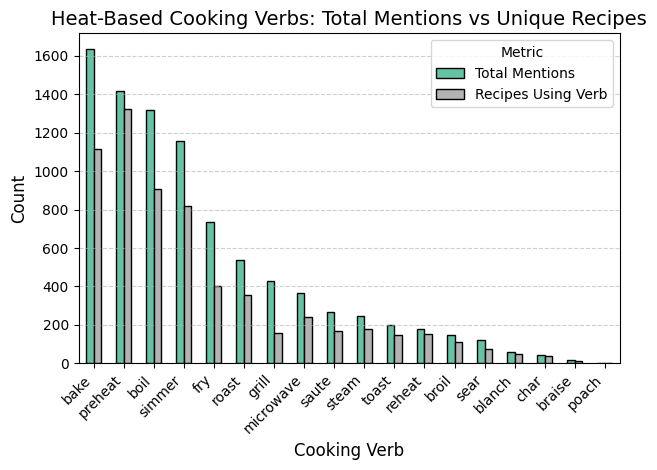

In [29]:
# Plot a grouped bar chart
plt.figure(figsize=(12, 6))
verb_stats.plot(kind='bar', edgecolor='black', colormap='Set2')

plt.title("Heat-Based Cooking Verbs: Total Mentions vs Unique Recipes", fontsize=14)
plt.xlabel("Cooking Verb", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend(title="Metric")
plt.show()

In [30]:
english_recipes_df['uses_heat'] = english_recipes_df['Instructions'].str.contains(
    '|'.join(verb_keywords), case=False, na=False)

To assess how well the dataset supports our goal of recommending recipes that are safe for using near-expiry ingredients, we analyzed the proportion of recipes that involve heat-based cooking.

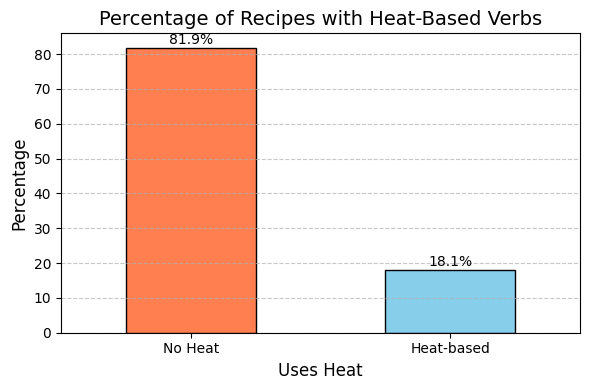

In [33]:
# Calculate percentages
heat_counts = english_recipes_df['uses_heat'].value_counts(normalize=True) * 100

# Plot the percentages with values on the bars
plt.figure(figsize=(6, 4))
bars = heat_counts.plot(kind='bar', color=['coral', 'skyblue'], edgecolor='black')
plt.title('Percentage of Recipes with Heat-Based Verbs', fontsize=14)
plt.xlabel('Uses Heat', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Heat', 'Heat-based'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage values on the bars
for i, value in enumerate(heat_counts):
    plt.text(i, value + 1, f'{value:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

This finding highlights a significant limitation in the dataset: the number of suitable recipes we can safely recommend to users is relatively small.

### Vegan/Vegetarian/Animal-Based Recipes

To support dietary personalization in the Anti-Food Waste Recommender, each recipe was classified into one of three categories: vegan, vegetarian, or meat-based. This classification was based on keyword matching within the ingredient lists. Animal-based ingredients such as "chicken", "bacon", and "tuna" flagged a recipe as animal-based, while the presence of animal-derived products like "milk", "cheese", or "honey" without meat resulted in a vegetarian label. Recipes free from both meat and animal by-products were labeled as vegan.

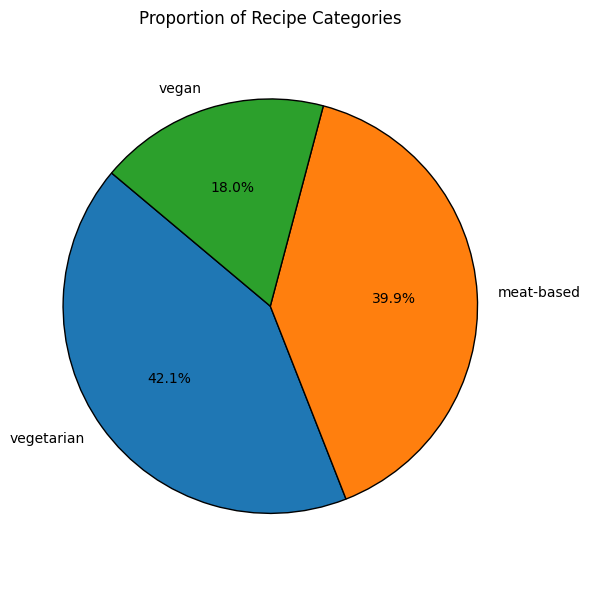

In [34]:
# Define ingredient keywords
meat_keywords = [
    "chicken", "beef", "pork", "bacon", "turkey", "sausage", "ham", "lamb", 
    "anchovy", "anchovies", "salmon", "tuna", "shrimp", "fish", "meat", 
    "prosciutto", "chorizo"
]
dairy_egg_keywords = [
    "egg", "milk", "cheese", "butter", "cream", "yogurt", "parmesan", "mozzarella"
]
non_vegan_keywords = dairy_egg_keywords + ["honey"]

# Classification function
def classify_recipe(ingredients_str):
    try:
        ingredients = ast.literal_eval(ingredients_str.lower())
    except Exception:
        ingredients = []

    has_meat = any(any(meat in ing for meat in meat_keywords) for ing in ingredients)
    has_non_vegan = any(any(item in ing for item in non_vegan_keywords) for ing in ingredients)

    if has_meat:
        return "meat-based"
    elif has_non_vegan:
        return "vegetarian"
    else:
        return "vegan"

# Apply the function to create a new column
english_recipes_df["Category"] = english_recipes_df["Ingredients"].apply(classify_recipe)

category_counts = english_recipes_df['Category'].value_counts()

# Plot the proportions as a pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Proportion of Recipe Categories')
plt.axis('equal')  # Keeps pie chart circular
plt.tight_layout()
plt.show()

# LLM

The LLM (Large Language Model) section of this project sits at the very core of our recipe recommendation system. Its main goal is to analyze and go through the obtained scraped recipes sourced from the web, making sure that the products near expiry inputted into our model are safely used. Therefore, with the help of an external LLM model, we can easily access the heat-processing viability of ingredients, get dietary restrictions of all recipes within our dataset, as well as classify cuisine styles, all of which are essential to the recommendation logic of our system.

Note that the data preparation and classification part of this section of the report, plus the merging of the LLM results, can be found in the notebook named `recipes_table_prep.ipynb`.

## Data Preparation and Classification

Before making use of the LLM, we go through preprocessing and classification of the data received from the scraping of the web recipes, so we only keep clean and relevant data moving forward.

### Data Normalization

The scraped data (`english_recipes.csv`) includes thousands of recipes in a somewhat formatted manner, containing a title, list of ingredients, recipe instructions, URL, and language metadata. We start by cleaning and standardizing, meaning that unnecessary columns (like URLs) are deleted, headers are renamed for consistency, and additional empty columns (like `ingredients_processed`, `heat_processed`, `cuisine_tags`, and `vegan`) are added to hold LLM-generated outputs. Furthermore, we also took into account possible missing values in the data however, none arose.

### Heat Processing Detection

A preliminary classification is conducted to flag recipes that likely involve heat. We do this by looking through the recipe's instructions and checking for the presence of heat-related keywords (e.g., "bake", "boil", "grill", "fry", "simmer", etc.). While this keyword-based check helps filter out possible irrelevant cases, it is definitely limited in the way it assesses whether specific ingredients within a recipe are actually cooked and therefore use heat in their processing. With this in mind, we address this limitation by taking advantage of the LLM that is used in further subsections.

### Dietary Classification

To further improve the dataset that will be used, a set of rule-based filters is applied to determine whether each recipe is vegetarian and/or vegan. To do so, we scan the raw ingredients of the recipes and take note of the non-vegetarian or non-vegan components using predefined lists. We made sure to include a wide range of products, from chicken, beef, and fish to less obvious ones such as gelatin, rennet, or casein. The logic can be seen below (as an example), in order to have clear thought process:

In [ ]:
"""
# Check if ingredients contain non-vegetarian/non-vegan items and update columns
df['vegetarian'] = df['ingredients_raw'].str.lower().apply(lambda x: not any(ingredient in str(x).lower() for ingredient in non_vegetarian_ingredients))
df['vegan'] = df['ingredients_raw'].str.lower().apply(lambda x: not any(ingredient in str(x).lower() for ingredient in non_vegetarian_ingredients + non_vegan_ingredients))
"""

In the end, each recipe is then labeled with a boolean tag indicating whether it is vegetarian and/or vegan.

### Recipe Batching for LLM Processing

Due to the large volume of data and the demands of modern language models, the cleaned dataset is divided into more manageable batches, as visible in the folder called `batched_recipes`. Each batch contains 200 recipes and is saved as a CSV file in the folder mentioned before.

# LLM Design and Logic

Once our recipe dataset has been cleaned, preprocessed, and batched, it is ready to go through the LLM model for further analysis. The code for such is in the `process_batch.py` Python file.

The model we use is Microsoft’s `Phi-3-mini-4k-instruct`, a state-of-the-art open model that is able to follow structured prompts and produce reliable outputs in JSON format. This model is run using low-memory 4-bit quantization to ensure compatibility with GPU-based HPC nodes while retaining high performance.

## Prompt Design

As input for the LLM, we give it the following prompt:

In [38]:
# --- Prompt Definition ---
PROMPT_TEMPLATE = """
<instruction>
Analyze the recipe for:
1. Heat processing of ingredients based on cooking instructions.
   Heat processing refers to any ingredient that is exposed to heat during preparation,
   including frying, boiling, sautéing, baking, or any cooking method that raises
   the temperature of the ingredient. Ingredients that are only mixed, soaked in room
   temperature water, or added after cooking are NOT heat processed.
   Provide the output as a JSON array of objects with "ingredient" and "heat_processed" keys.
2. Identify 3 cuisine types that best match this recipe.
   Examples of cuisines include:
   - Regional cuisines: Italian, Mexican, Chinese, Japanese, Korean, Thai
   - Indigenous cuisines: Inuit, Maori, Native American, Aboriginal Australian
   - Fusion cuisines: Tex-Mex, Peranakan, Chifa, Nikkei
   - Island cuisines: Faroese, Canarian, Hawaiian, Okinawan
   Provide the output as a JSON array of strings.
</instruction>

<input>
Ingredients:
{ingredients}

Instructions:
{instructions}
</input>

<output_format>
{{
  "heat_processing": [{{"ingredient": "name", "heat_processed": true/false}}],
  "cuisine_types": ["cuisine1", "cuisine2", "cuisine3"]
}}
</output_format>

<output>
""" 

Therefore, the LLM is explicitly instructed to perform two tasks:
1. Heat Processing Classification: For each ingredient in its corresponding recipe, the LLM determines whether it undergoes any heat treatment during the recipe's preparation. This goes beyond keyword matching, making the model search through the specific context from the instructions (e.g., knowing that “simmer the sauce with onions” implies that onions are heat-processed).

2. Cuisine Classification: Identify the three best-matching cuisine types for the recipe at hand. This can go from anything to everything, including, for example, regional cuisines (e.g., Mexican, Italian), indigenous or local styles (e.g., Inuit, Canarian), or fusion cuisines (e.g., Tex-Mex, Peranakan).

The LLM is then required to output its results in a structured JSON format.

It should also be mentioned that, with each prompt fed into the LLM, a structured response is awaited back. If any error is due to occur - such as a malformed JSON, incomplete outputs, or unexpected content - they are added in a dedicated `processing_error` column for transparency and potential reprocessing.

# Post-Processing and Dataset Merging

Once all batches have been processed by the LLM, its results can all be seen in the `LLM/batched_recipes_results` folder. As the final dataset is still batched and therefore divided into multiple parts, we come back to the `recipes_table_prep.ipynb` notebook to merge all of them into a unified dataset. Such consolidates the original recipe content with the LLM-generated fields: heat processing per ingredient, cuisine classification, and any error logs. At this stage, final cleaning and reordering of columns take place, and the full dataset (`LLM/merged_final_results.csv`) becomes ready for integration into the application front end.

# App

To go beyond a theoretical solution, we decided to create a functional app/website taking all the model logic so far mentioned, which allows possible users to actually interact with the system designed in a real, more tangible way. With this approach, we aim to close the gap between technical data analysis and real-world business applications, making our project both practical and impactful. The full application logic and code are contained within a single Python script (`App/app.py`), with clear inline comments to explain each step.

Using the Streamlit framework, we designed the app to be impactful, motivational, and informative. Therefore, to start, we added a motivational image related to food waste, helping to capture the user’s attention and set the tone. Following this, a short introductory section is provided with the title, our mission, and some bullet points that highlight the scale of food waste globally, its importance, and what our website does to help tackle it.

To ensure we can successfully match the user input ingredients with the ingredients in our database, two helper functions were created. The first, `normalize_ingredient_name`, standardizes user input by converting it to lowercase and removing plural endings where appropriate. The second function, `match_ingredient`, compares the user input product with the ingredients in the recipe database using a normalized representation of each. It supports partial matching when the user provides a single-word input, allowing flexibility (e.g., matching "tomato" with "cherry tomato"). However, when the input contains multiple words, the function requires an exact match, ensuring precision in more specific queries (e.g., "cherry tomato" must match exactly to "cherry tomato" in the ingredient dataset). It is to note that, if the user's input has spelling mistakes, the system may not find a matching recipe in our data, as it was not feasible within the current timeframe to incorporate error correction or suggestion features. Nevertheless, implementing these functionalities could be a very valuable and feasible improvement for further development of the project in the future.

Furthermore, dietary preferences (vegan and vegetarian) are collected with no default preselection (`index=None`), making sure that the users freely choose their dietary preferences. The app verifies that these fields are completed before allowing the search to proceed, with clear warnings if the inputs are missing. The users' responses are stored in boolean variables, `vegan` and `vegetarian`, which are later used to filter recipes.

In addition to dietary preferences, users can further personalize their recipe discovery by selecting cuisine type and other relevant tags, although it is not mandatory to do so. We use a predefined whitelist of valid cuisine categories to ensure only meaningful and standardized options are shown, including both regional styles (such as "Italian" or "Korean") and more specific or hybrid cuisines (like "Tex-Mex" or "Indo-Caribbean"). These tags are extracted from the `cuisine_tags` field in the dataset. Any tags not found in the whitelist but we still found them potentially useful, as “Street Food” or “Spicy”, are visible under an “Other Tags” filter. 

Thereafter, the users arrive at the stage to input the near-expiry ingredients they have at hand. They do so within the `🥬 Enter Ingredients` section of the app, where there is a highlighted section to be aware of spelling mistakes, plus a text box to add the aforementioned ingredients. There can be more than one item input at once, but they need to be comma-separated, as it is mentioned in the user input area. 

During development, we identified a data inconsistency where some recipes that included steak were incorrectly labeled as both vegan and/or vegetarian. To address this, we introduced a step in the logic that explicitly overrides the dietary classification of any recipe that includes steak in its ingredients, ensuring the integrity of filtering based on user preferences.

Once the dietary selections and ingredient(s) are provided, the users are instructed to press the "Find Recipes" button, which loads the recipe data `(df = pd.read_csv('LLM/merged_final_results.csv'))`, which contains all previously enriched and filtered recipes. Matching recipes are found using the `find_heat_processed_ingredient` function, which checks that all user-provided ingredients match those that have been cooked in a recipe, while also respecting any dietary restrictions. 

If matching recipes are found, the app first presents a list of recipe titles that match the criteria input. To improve navigability, each title is a clickable link, allowing users to quickly jump to the full details of that same recipe. Such is followed by detailed information for each recipe, including ingredients and step-by-step instructions. Each recipe detail section also includes a “🔝 Back to top” link, allowing users to return to the search engine of the app without having to scroll manually. Nevertheless, if no matching recipes are present, the app shows a text warning, ensuring that the user experience remains clear and informative.

Throughout the app and its code, we make sure to integrate strong error handling and a good overall structure, separating normalization, matching, and filtering into individual functions, to ensure that the app is easy to understand and scalable.

By creating a functional app rather than just a static report, we wanted to simulate how this project could be applied in the real world. In practice, users would simply input what ingredients they have at home that are about to go bad, and immediately receive meal ideas tailored to their needs, dietary restrictions, and available food, thus minimizing waste and maximizing resource use.

# Limitations

# Conclusions

With this project, we aim to show how advanced business analytics can be applied to a real-world problem. We built an end-to-end solution that starts with large-scale recipe data scraping and continues through data cleaning and analysis, rule-based classification, and semantic enrichment using a Large Language Model (LLM). The LLM enabled accurate detection of heat-processed ingredients and cuisine classification, which supported our goals of food safety and user personalization.

We implemented dietary filtering and displayed our results through an interactive front-end application that simulates how users might search for recipes based on near-expiry ingredients. Therefore, with this project, we hope to demonstrate how combining data analysis, natural language processing, and user-centered design can create an effective end-to-end process. Such that delivers actionable insights across key focus areas nowadays - sustainability, decision support, and real-world applicability.